In [20]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import collections
#from colour import Color
from random import choice, random
#from mpl_toolkits import mplot3d

def user_to_series(dict_obj):
    """Convert a nested JSON user to a flat pandas series"""
    renamed = {}
    for k in dict_obj.keys():
        nk = "user_%s" % k
        v = dict_obj[k]
        renamed[nk] = v
    ret = pd.Series(renamed)
    return ret
    
# I know there are better ways to do this but I was in a rush to get it done
def add_reply_username(df):
    out = []
    for uid in list(df["in_reply_to_account_id"].values):
        if uid is None:
            out.append(np.nan)
            continue
        user_name = df[df["user_id"]==uid]["user_screen_name"].values[0]
        out.append(user_name)
    copy = df.copy()
    copy["in_repy_to_screen_name"] = out
    return copy

series_data = [] # 1 JSON object per toot object
with open("fake_toots.json") as data:
    text = data.read().strip()
    rows = text.split("\n")  # JSON objects stored as list of strings
for row in rows:
    obj = json.loads(row) # Converted row string to JSON object
    series_data.append(obj) # Add to JSON list
    
toot_df = pd.DataFrame(series_data) # 1 row per JSON obj
toot_df = pd.concat([toot_df, toot_df['account'].apply(user_to_series)], axis=1)
# Now the data is flattened. We remove the field containing the JSON object
toot_df.drop("account", axis=1, inplace=True)
toot_df = add_reply_username(toot_df)
toot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28034 entries, 0 to 28033
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      28034 non-null  int64  
 1   created_at              28034 non-null  object 
 2   source                  28034 non-null  object 
 3   content                 28034 non-null  object 
 4   in_reply_to_account_id  10302 non-null  object 
 5   in_reply_to_id          10302 non-null  float64
 6   reblogs_count           28034 non-null  int64  
 7   favourites_count        28034 non-null  int64  
 8   user_id                 28034 non-null  object 
 9   user_screen_name        28034 non-null  object 
 10  user_location           28034 non-null  object 
 11  user_description        28034 non-null  object 
 12  user_url                28034 non-null  object 
 13  in_repy_to_screen_name  10302 non-null  object 
dtypes: float64(1), int64(3), object(10)
me

We can also examine the number of unique users in the data

In [22]:
len(toot_df["user_screen_name"].unique())

84

# Social Network Graphs

This notebook accompanies chapter 5 of the book "Applied Math for Security". This code is used to show the manipulation of data similar to that returned by many social networks .In this case the data is modeled after the Twitter network. No actual Twitter data was used to maintain privacy, but the field names for the API responses were taken directly from the documentation at the time of writing.

In [3]:
o_toots = toot_df[toot_df["in_reply_to_screen_name"].isna() == True]
r_toots = toot_df[toot_df["in_reply_to_screen_name"].isna() == False]
if len(r_toots.index.to_list()) != 0:
    replied_to = r_toots["in_reply_to_id"].values
    o_no_r = o_toots.loc[o_toots["id"].isin(replied_to) == False]
    p_len = float(len(o_no_r.index.to_list()))
    o_len = float(len(o_toots.index.to_list()) - p_len)

    info_exchange = float(p_len / o_len)
else:
    info_exchange = -1
print("The ratio of Potential to Kinetic Information is: %.4f " % info_exchange)

The ratio of Potential to Kinetic Information is: 2.6358 


The next cell generates the first image in the chapter which is a 3D representation of the graph we define. Using a 3D plot in Matplotlib is very similar to using 2D plots with a lot of the same customization parameters.

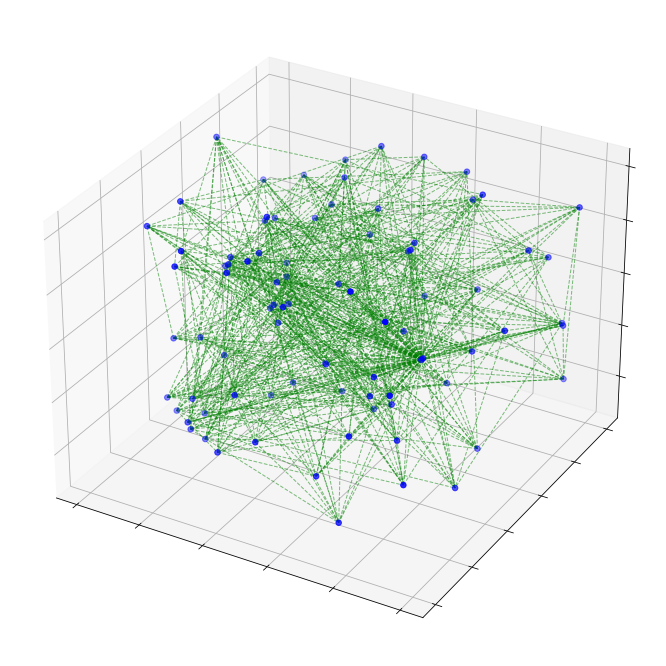

In [4]:
G = nx.DiGraph()

for idx in tweet_df.index:
    row = tweet_df.loc[idx]
    G.add_node(row["user_screen_name"])
    if row["in_reply_to_id"] != np.nan:
        G.add_edge(row["in_reply_to_screen_name"],row["user_screen_name"])
z_layers = range(1,11)
pos = nx.random_layout(G)
x = []
y = []
z = []
for k in pos.keys():
    layer = choice(z_layers)
    pos[k] = (pos[k][0], pos[k][1], layer)
    x.append(pos[k][0])
    y.append(pos[k][1])
    z.append(layer)


fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111, projection="3d")

# Loop over the edges in the graph to create line segments on the plot
for ed in G.edges.keys():
    u_pos = pos[ed[0]]
    v_pos = pos[ed[1]]
    # plot the edge in 3D usng the previously defined positions
    lx, ly, lz = [u_pos[0], v_pos[0]], [u_pos[1], v_pos[1]], [u_pos[2], v_pos[2]]
    ax1.plot(lx, ly, lz, "--g", alpha=0.01, linewidth=1)

ax1.scatter(x, y, z, s=30, c='b', marker='o')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])
for l in fig.gca().lines:
    l.set_alpha(.5)
#plt.savefig("Figure_5-1.svg", format="svg")
#plt.savefig("Figure_5-1.png")
plt.show()

Now we are going to create another graph of the tweets and responses. First we are going to create a list of the tweets which never received a reply

In [5]:
# Create a list of IDs for tweets without replies
replied_to_ids = tweet_df[tweet_df["in_reply_to_tweet_id"].isna() == True]["in_reply_to_tweet_id"].values
onr = tweet_df[tweet_df["in_reply_to_tweet_id"].isna() == True & (tweet_df["id"].isin(replied_to_ids) == False)]
o_no_r_index = [int(i) for i in list(o_tweets.loc[o_tweets["id"].isin(replied_to) == False]["id"].unique())]
o_no_r_index

[4912964953915055,
 7569347381291484,
 8879321561721462,
 5332426379310993,
 905516268841238,
 3141108490772626,
 1798864591998975,
 7989713818918154,
 6424693763363360,
 9110494317353611,
 2731052273401196,
 3248257722579598,
 8324056648806998,
 8154073377430262,
 1691350911180099,
 2171931366322530,
 3904700488505512,
 4950829129400517,
 7617009309102860,
 7603265874750637,
 1845473004007569,
 8190425400804210,
 1549486644063971,
 9782717690075762,
 4821533010585420,
 7165682647632758,
 2955391429905133,
 6946421904142858,
 824538813717372,
 2733095456694021,
 9779315170159154,
 922769638391454,
 2114736465044538,
 7739407484009212,
 1853559231779125,
 1731075095092049,
 5616476784277413,
 2239997342852844,
 3071290042640337,
 6104092482072484,
 3147435170609541,
 7803264826670869,
 6302401265621446,
 1537437744665476,
 8939472967222272,
 1729927146115811,
 4119606511819874,
 9422394616482110,
 5737565913725287,
 6178824570272306,
 5064637192371109,
 534645276023873,
 556656081663400

Now we create the graph using the same methodology as the previous user graph. In this case the direction of the arrow follows the logic that the tweet's ID creates a directed edge to the tweet which it is in reply to.

In [6]:
# Create the graph object by iterating over each tweet in the data
tG = nx.DiGraph()
for idx in tweet_df.index:
    row = tweet_df.loc[idx]
    tG.add_node(row["id"])
    if np.isnan(row["in_reply_to_tweet_id"]) == False:
        tG.add_edge(row["id"],row["in_reply_to_tweet_id"])

We are going to color the figure based on the type of tweet it is and whether or not it was popular.
- Isolated = orange
- original with average number of replies = blue
- origin with a high number of replies = green
- a reply = yellow

In [7]:
# This calculates the mean number of replies for tweets
reply_counts = np.array([tG.in_degree(n) for n in tG.nodes()])
above_avg_threshold = reply_counts.mean() + (1.5*reply_counts.std())

# Create a list of colors based on the type of tweet

colors = []
for n in tG.nodes:
    if int(n) in o_no_r_index:
        colors.append("orange")
    elif tG.in_degree(n) > above_avg_threshold:
        colors.append("green")
    elif tG.out_degree(n) > 0:
        colors.append("yellow")
    else:
        colors.append("blue")

Finally we plot the graph. I have commented out the line which adds the edges to the output because they make it indistinguishable for the most part. This image wasn't included in the text because it relies heavily on the colorization. It can be useful to visualize you data in color coded point clouds when you want to get a sense of the categorical makeup of data like we are doing here. If you're color blind, I apologize. This image will likely be of no use to you.

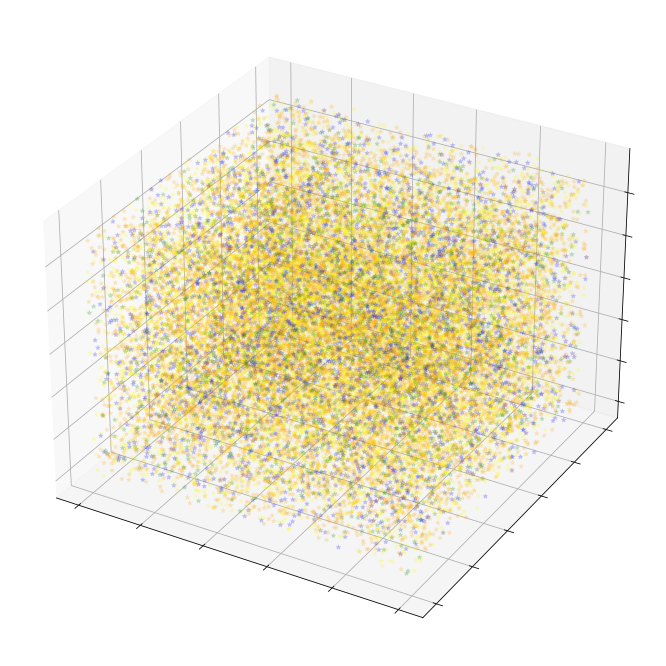

In [8]:
z_layers = range(1,int(len(tweet_df.index))*4)
t_pos = nx.random_layout(tG)
tx = []
ty = []
tz = []

for k in t_pos.keys():
    t_layer = choice(z_layers)
    t_pos[k] = (t_pos[k][0], t_pos[k][1], t_layer)
    tx.append(t_pos[k][0])
    ty.append(t_pos[k][1])
    tz.append(t_layer)

no_reply = [node for node in G.nodes if G.out_degree(node) == 0]

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111, projection="3d")

# Loop over the edges in the graph to create line segments on the plot
for ed in tG.edges.keys():
    u_pos = t_pos[ed[0]]
    v_pos = t_pos[ed[1]]
    # plot the edge in 3D usng the previously defined positions
    lx, ly, lz = [u_pos[0], v_pos[0]], [u_pos[1], v_pos[1]], [u_pos[2], v_pos[2]]
    # Uncomment this line to add the edges to the plot
    #ax1.plot(lx, ly, lz, "-.", color="black", alpha=0.001, linewidth=0.1)

ax1.scatter(tx, ty, tz, s=20, c=colors, alpha=0.15, marker='*')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])
for l in fig.gca().lines:
    l.set_alpha(.5)
plt.show()

The next cell begins preparing the data for analysis by removing NaN values and casting the in_reply_to_tweet_id and in_reply_to_user_id columns to integers

In [9]:
tweet_df.sort_values(by="retweet_count", inplace=True)
tweet_df.tail()

,id,id_str,created_at,text,source,retweet_count,liked_count,in_reply_to_user_id,in_reply_to_tweet_id,in_reply_to_user_id_str,in_reply_to_screen_name,user_id,user_screen_name,user_location,user_description,user_url
410,8771011140401964,8771011140401964,2019-5-22 17:22:07,Same piece majority expect send provide artist...,Data Faker,9,2,NaN,NaN,NaN,NaN,3123918413827,tclark,USCGC Smith\nFPO AA 12675,Faked profile Data,https://www.hughes.info/
415,1478320922453776,1478320922453776,2019-5-22 11:23:55,Newspaper practice police reason within inside.,Data Faker,9,2,NaN,NaN,NaN,NaN,1223631570240,georgejohnson,"655 Wyatt Isle Apt. 039\nEast Nicoleton, MO 23012",Faked profile Data,https://jackson.com/
76,3043394393021305,3043394393021305,2019-5-22 05:43:49,Very father with approach between task charact...,Data Faker,9,2,NaN,NaN,NaN,NaN,7901654492070,andrew38,"06520 Garcia Ferry Suite 027\nNicholasshire, I...",Faked profile Data,http://www.ortega-miller.com/
1547,2707697234989310,2707697234989310,2019-5-23 13:31:56,Represent partner three least that effort else...,Data Faker,9,1,NaN,NaN,NaN,NaN,4549931860704,dannyhoover,"5298 Maria River\nTracyhaven, MD 02691",Faked profile Data,http://cooke.com/
311,1701186839916835,1701186839916835,2019-5-22 07:40:34,Positive party officer woman nearly somebody.,Data Faker,11,0,NaN,NaN,NaN,NaN,0544987316544,levinemarc,"0010 Tara Loop Apt. 555\nMorganside, UT 29794",Faked profile Data,https://johnston.com/


In [10]:
tweet_df.dropna(axis=0, inplace=True)
tweet_df["in_reply_to_tweet_id"] = tweet_df["in_reply_to_tweet_id"].astype(int)
tweet_df["in_reply_to_user_id"] = tweet_df["in_reply_to_user_id"].astype(int)

G = nx.DiGraph()

for idx in tweet_df.index:
    row = tweet_df.loc[idx]
    G.add_edge(row["in_reply_to_screen_name"], row["user_screen_name"], capacity=len(row["text"]))
#print(len(G.nodes))

This code makes a directed edge which flows from the referenced user to the user making the reference (a 'retweet'). The direction of the edge indicates the direction of information travel, from message initiator to message repeater.

Nodes with higher outdegrees are more influential in the sense that more nodes chose to respond to their messages.

In [11]:
pos=nx.shell_layout(G)
pos = {k: (pos[k][0], pos[k][1]) for k in pos.keys()}
nx.set_node_attributes(G, pos, "loc")

In [12]:
uG = nx.to_undirected(G)
cliques = list(nx.algorithms.clique.find_cliques(uG))

dannyhoover is in 3 cliques. They have out-degree 12 and O.D. Centrality of 0.1446


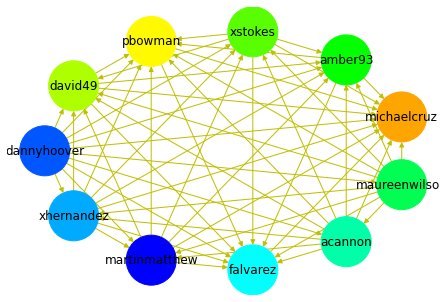

In [13]:
deg_ct = G.out_degree()
deg_ctr = nx.out_degree_centrality(G)
sorted_deg = sorted(deg_ct, key=lambda kv: kv[1])
top_source = sorted_deg[-1]
source_cliques = [c for c in cliques if top_source[0] in c]
msg = "%s is in %d cliques. They have out-degree %d and O.D. Centrality of %.4f"
print(msg % (
    top_source[0],
    len(source_cliques),
    top_source[1],
    deg_ctr[top_source[0]]
    )
)
c_size = len(source_cliques[0])
sG = G.subgraph(source_cliques[0])
sub_pos = {}
blue = Color("blue")
colors = list(blue.range_to(Color("orange"),c_size))
colors = [c.rgb for c in colors]
for i in range(c_size):
    name = source_cliques[0][i]
    sub_pos[name] = G.nodes[name]["loc"]
    sG.nodes[name]["color"] = colors[i]
cm = [sG.nodes[n]["color"] for n in sG.nodes.keys()]
nx.draw_shell(sG, node_color=cm, node_size=2500, with_labels=True, edge_color="y")
#plt.savefig("Figure_5-2.svg", format="svg")
#plt.savefig("Figure_5-2.png")

In [14]:
print(sG.in_degree())

[('dannyhoover', 0), ('xhernandez', 3), ('martinmatthew', 4), ('falvarez', 9), ('acannon', 2), ('maureenwilson', 1), ('michaelcruz', 10), ('amber93', 7), ('xstokes', 5), ('pbowman', 8), ('david49', 6)]


Due to the algorithm implemented in NetworkX, the worst-case memory complexity for the cliques list is exponential, with respect to the number of nodes in the graph. This case arises for complete graphs. 

In [15]:
deg_ct = G.in_degree()
deg_ctr = nx.in_degree_centrality(G)
sorted_deg = sorted(deg_ct, key=lambda kv: kv[1])
top_source = sorted_deg[-1]
source_cliques = [c for c in cliques if top_source[0] in c]
msg = "%s is in %d cliques. They have in-degree %d and I.D. Centrality of %.4f"
print(msg % (
    top_source[0],
    len(source_cliques),
    top_source[1],
    deg_ctr[top_source[0]]
    )
)

juliekennedy is in 2 cliques. They have in-degree 11 and I.D. Centrality of 0.1325


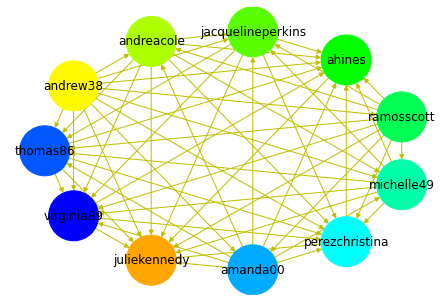

In [16]:
# Locate the biggest clique using a loop this time
biggest_clique = None
clique_size = 0
for cliq in source_cliques:
    if len(cliq) > clique_size:
        clique_size = len(cliq)
        biggest_clique = cliq

# Create the subgraph of the biggest clique
sG = G.subgraph(biggest_clique)
sub_pos = {}
blue = Color("blue")
colors = list(blue.range_to(Color("orange"),c_size))
colors = [c.rgb for c in colors]
for i in range(clique_size):
    name = source_cliques[0][i]
    sub_pos[name] = G.nodes[name]["loc"]
    sG.nodes[name]["color"] = colors[i]
cm = [sG.nodes[n]["color"] for n in sG.nodes.keys()]
nx.draw_shell(sG, node_color=cm, node_size=2500, with_labels=True, edge_color="y")
#plt.savefig("Figure_5-2.svg", format="svg")
#plt.savefig("Figure_5-2.png")

erica92 is 10 ::  0.12048192771084337
madison91 is 9 ::  0.12048192771084337
ramosscott is 8 ::  0.12048192771084337
judith20 is 7 ::  0.13253012048192772
georgejohnson is 6 ::  0.13253012048192772
bentonmichael is 5 ::  0.13253012048192772
vkhan is 4 ::  0.13253012048192772
bryannichole is 3 ::  0.13253012048192772
andrew38 is 2 ::  0.13253012048192772
dannyhoover is 1 ::  0.14457831325301207


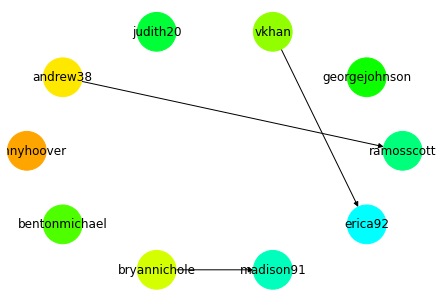

In [17]:

deg_ctr = nx.out_degree_centrality(G)
sorted_deg = sorted(deg_ctr.items(), key=lambda kv: kv[1])
blue = Color("cyan")
colors = list(blue.range_to(Color("orange"),10))
colors = [c.rgb for c in colors]
sorted_dict = collections.OrderedDict(sorted_deg)
top_ten = list(sorted_dict.keys())[-10:]
sG = G.subgraph(top_ten)
sub_pos = {}
for i in range(10):
    name = top_ten[i]
    sub_pos[name] = G.nodes[name]["loc"]
    sG.nodes[name]["color"] = colors[i]
    print("%s is %i :: " % (name, 10-i), deg_ctr[name])
cm = [sG.nodes[n]["color"] for n in sG.nodes.keys()]
nx.draw_shell(sG, node_color=cm, node_size=1500, with_labels=True)

Already it is easier to tell who the influencers and consumers of the information are on this network. If we convert the graph to an undirected graph we can measure the communicability of all the nodes in the network

garciajames is 10 :: 0.27646640570965525
jacksonjanet is 9 :: 0.27646640570965564
fguerrero is 8 :: 0.27646640570965575
judith20 is 7 :: 0.2815256655036768
bentonmichael is 6 :: 0.28152566550367697
andrew38 is 5 :: 0.28152566550367736
dannyhoover is 4 :: 0.2815256655036774
vkhan is 3 :: 0.2815256655036774
georgejohnson is 2 :: 0.28152566550367747
bryannichole is 1 :: 0.28152566550367764


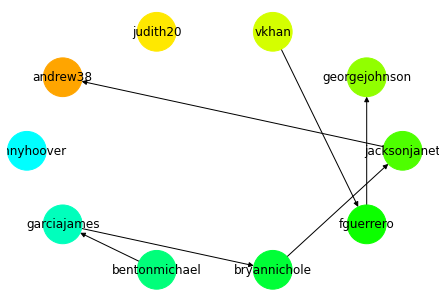

In [18]:
comm_scores = nx.communicability_betweenness_centrality(nx.to_undirected(G))
sorted_comm = sorted(comm_scores.items(), key=lambda kv: kv[1])
sorted_dict = collections.OrderedDict(sorted_comm)
blue = Color("cyan")
colors = list(blue.range_to(Color("orange"),10))
colors = [c.rgb for c in colors]
top_ten = list(sorted_dict.keys())[-10:]
sG = G.subgraph(top_ten)
for i in range(10):
    name = top_ten[i]
    sG.nodes[name]["color"] = colors[i]
    print("%s is %i ::" % (name, 10 - i), comm_scores[name])
cm = [sG.nodes[n]["color"] for n in sG.nodes.keys()]
nx.draw_shell(sG, node_color=colors, node_size=1500, with_labels=True)

These are the 10 nodes with the highest communicability in this network. We can see that the user janeevans plays a prominent role in communicating information to the rest of the network. Practically this answers the question "<i>which nodes are statisically likely to communicate something through the largest segment of the network</i>". The "something" could be a piece of data (like a tweet), a document, or anything else which might be communicated over the network medium. During offensive security exercises, one might choose to focus a spear phishing campaign against the k users with the highest communicability score. Infosec defenders can use the communicability information to understand how a malicious attachment (or misinformation) might propogate through their users.

The most influential user is bryannichole


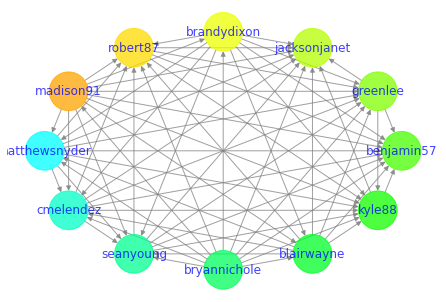

In [19]:
most_influence = list(sorted_dict.keys())[-1]
print("The most influential user is %s" % most_influence)
neighbors_1 =  list(G.neighbors(most_influence))
neighbors_1.append(most_influence)
colors = list(blue.range_to(Color("orange"),len(neighbors_1)))
cm = [c.rgb for c in colors]
sG = G.subgraph(neighbors_1)
nx.draw_shell(
    sG,
    with_labels=True,
    node_color=cm,
    node_size=1500,
    alpha=0.75,
    font_color="blue",
    edge_color="gray"
)

The above graph shows the relationship to the most influential user. At some point in time, each of these people has referenced information in a tweet posted by this user. This network is highly connected. It shows that users connected to janeevans have also responded to information from others who have also refereneced her material. This may indicate a strong association among these nodes. Conversly we may be interested in who absorbs the most information in the network. This can be seen as a function of the number of incoming and outgoing edges over time. The next few algorithms are designed to work specifically on Acyclic Directed Graphs, but the NetworkX implementations rarely validate this property is true for the graph being examined. Let's verify we are indeed working with an Acyclic Directed Graph.

In [20]:
nx.is_directed_acyclic_graph(G)

True

Google's pagerank algorithm is probably one of the most well known iterative information flow algorithm. It describes the link structure between Websites on a given topic (or set of topics), wherein the edges are outbound link references to another site. The intuition behind the algorithm is: pages which have a high number of references probably contain the most authorative material on a subject. Here we are flipping this intuition on it's head. The nodes with the highest page rank, given our definition of inormation flow, are those nodes who are most likely to consume information from the network (as measured by the amount of information the replied to on the network).

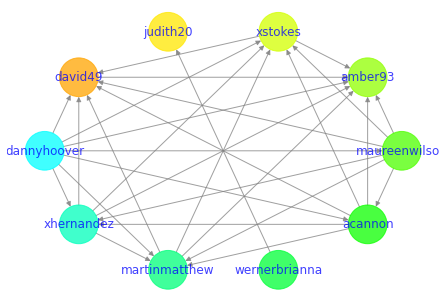

In [21]:
page_rank = nx.algorithms.link_analysis.pagerank(G)
sorted_rank = sorted(page_rank.items(), key=lambda kv: kv[1])
sorted_dict = collections.OrderedDict(sorted_rank)
nx.set_node_attributes(G, page_rank, "pg")
colors = list(blue.range_to(Color("orange"), 10))
cm = [c.rgb for c in colors]
sG = G.subgraph(list(page_rank.keys())[:10])
nx.draw_shell(sG, with_labels=True, node_color=cm, node_size=1500, alpha=0.75, font_color="blue", edge_color="gray")

The Hyperlink-Induced Topic Search (HITS) algorithm discussed in the book has been used in the past to rate the importance of scientific journal entries. It is nicknamed "Hubs and AuthoritiesThe intuition behind this algorithm is simple: More important entries will be cited by a higher number of other entries. It is designed with the same directionality as we have defined previously.

In [22]:
tweet_df["text"] = tweet_df["text"].str.lower()
env_rows = tweet_df[tweet_df["text"].str.contains("environment")]
env_replies = tweet_df[tweet_df["in_reply_to_tweet_id"].isin(env_rows["id"].values)]
#env_replies

hG = nx.DiGraph()
for idx in env_replies.index:
    row = env_replies.loc[idx]
    hG.add_edge(row["in_reply_to_screen_name"], row["user_screen_name"])

hub_scores, auth_scores = nx.hits(hG, max_iter=1000, tol=0.01)
sorted_hub = sorted(hub_scores.items(), key=lambda kv: kv[1])
sorted_hub = collections.OrderedDict(sorted_hub)
sorted_auth = sorted(auth_scores.items(), key=lambda kv: kv[1])
sorted_auth = collections.OrderedDict(sorted_auth)
print("The top 3 hubs for environment are: %s" % ",".join(list(sorted_hub)[-3:]))

The top 3 hubs for environment are: nromero,victoria73,williamclarke


In [23]:
pol_rows = tweet_df[tweet_df["text"].str.contains("politic")]
pol_replies = tweet_df[tweet_df["in_reply_to_tweet_id"].isin(pol_rows["id"].values)]
hG2 = nx.DiGraph()
for idx in pol_replies.index:
    row = pol_replies.loc[idx]
    hG2.add_edge(row["in_reply_to_screen_name"], row["user_screen_name"])
hub_scores, auth_scores = nx.hits(hG2, max_iter=1000, tol=0.01)
sorted_hub = sorted(hub_scores.items(), key=lambda kv: kv[1])
sorted_hub = collections.OrderedDict(sorted_hub)
sorted_auth = sorted(auth_scores.items(), key=lambda kv: kv[1])
sorted_auth = collections.OrderedDict(sorted_auth)
print("The top 3 authorities for politics are: %s" % ", ".join(list(sorted_auth)[-3:]))

The top 3 authorities for politics are: susanjohnson, trivera, wernerbrianna


The next cell defines two spring layouts, one for each of the topic subgraphs. The spring_layout positions nodes using the Fruchterman-Reingold force-directed algorithm. The algorithm creates a spring like attractive force for every pair of nodes ( i , j ) where the ideal length $\delta _{ij}$ of each spring is proportional to the graph-theoretic distance between nodes i and j, without using a separate repulsive force. The combination of attractive forces on adjacent vertices, and repulsive forces on all vertices, was first used by Eades (1984) additional pioneering work on this type of force-directed layout was done by Fruchterman & Reingold (1991)

Text(0.5, 1.0, 'Pol. graph')

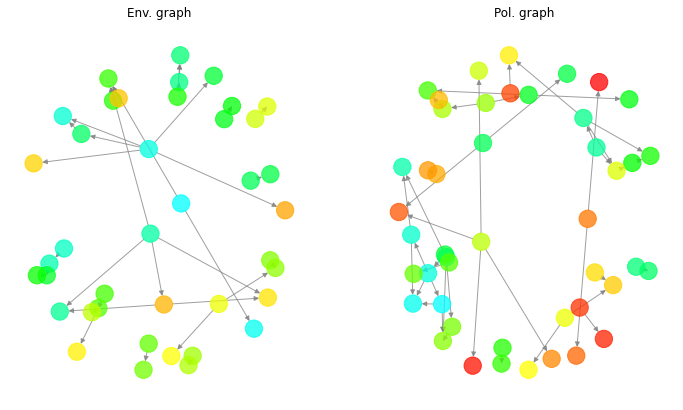

In [24]:
colors1 = list(blue.range_to(Color("orange"), len(hG.nodes)))
colors2 = list(blue.range_to(Color("Red"), len(hG2.nodes)))
cm1 = [c.rgb for c in colors1]
cm2 = [c.rgb for c in colors2]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7))
nx.draw_spring(hG, alpha=0.75, node_color=cm1, edge_color="gray", ax=ax1)
nx.draw_spring(hG2, alpha=0.75, node_color=cm2, edge_color="gray", ax=ax2)
ax1.set_title("Env. graph")
ax2.set_title("Pol. graph")
#plt.savefig("Figure_5-4.svg", format="svg")
#plt.savefig("Figure_5-4.png")

# Cliques and influence
The next set of cells contain the code for finding and creating clique subgraphs from the tweet data.

In [25]:
clique_res = {}
for u in G.nodes.keys():
    in_cliques = [c for c in cliques if u in c and len(c) > 2]
    clique_res[u] = len(in_cliques)
sorted_clique_counts = sorted(clique_res.items(), key=lambda kv: kv[1])

In [26]:
in_cliques = [c for c in cliques if "gutierrezjamie" in c and len(c) > 2]

The maximal independent set Returns a random maximal independent set guaranteed to contain a given set of nodes. The returned list is a set of nodes such that the subgraph of G induced by these nodes contains no edges. A maximal independent set is an independent set such that it is not possible to add a new node and still get an independent set.

In [27]:
nx.maximal_independent_set(G.to_undirected())

['falvarez',
 'nromero',
 'sabrinaward',
 'ramosscott',
 'cmelendez',
 'carolstevens',
 'williamwiggins']

In [28]:
pairs = []
for i in range(len(G.nodes.keys()) - 2):
    k1 = list(G.nodes.keys())[i]
    for j in range(len(G.nodes.keys())):
        k2 = list(G.nodes.keys())[j]
        if k1==k2:
            continue
        cut_value, partition = nx.minimum_cut(G, k1, k2)
        reachable, unreachable = partition
        cutset = set()
        for u, nbrs in ((n, G[n]) for n in reachable):
            cutset.update((u, v) for v in nbrs if v in unreachable)
        if len(cutset) == 0:
            continue
        pairs.append(((k1, k2), len(cutset), cutset, reachable, unreachable))

In [29]:
in_deg = list(G.in_degree())
in_deg = sorted(in_deg, key=lambda x: x[1], reverse=True)
print(in_deg)

[('juliekennedy', 11), ('wernerbrianna', 10), ('trivera', 10), ('garciabrenda', 10), ('michelle63', 10), ('michaelcruz', 10), ('bethanyturner', 10), ('fguerrero', 10), ('fbrown', 10), ('benjamin57', 10), ('jacksonjanet', 10), ('wrightlynn', 10), ('garciajames', 10), ('hartmanmatthew', 10), ('lunajeffrey', 9), ('williamwiggins', 9), ('iwatkins', 9), ('falvarez', 9), ('jaygreen', 9), ('kyle88', 9), ('ahines', 9), ('ewhitney', 8), ('susanjohnson', 8), ('daniel99', 8), ('pbowman', 8), ('craig00', 8), ('greenlee', 8), ('perezchristina', 8), ('amber93', 7), ('jessicaclark', 7), ('millertina', 7), ('shannon42', 7), ('youngjoel', 7), ('robert87', 7), ('virginia89', 7), ('david49', 6), ('twright', 6), ('todd54', 6), ('grosslinda', 6), ('maria04', 6), ('seanyoung', 6), ('thomas86', 6), ('xstokes', 5), ('petersondaniel', 5), ('shawn33', 5), ('gutierrezjamie', 5), ('victoria73', 5), ('cmelendez', 5), ('jacquelineperkins', 5), ('martinmatthew', 4), ('uflynn', 4), ('christopherjones', 4), ('carolste

In [30]:
out_deg = list(G.out_degree())
out_deg = sorted(out_deg, key=lambda x: x[1], reverse=True)
print(out_deg)

[('dannyhoover', 12), ('judith20', 11), ('georgejohnson', 11), ('bentonmichael', 11), ('vkhan', 11), ('bryannichole', 11), ('andrew38', 11), ('maureenwilson', 10), ('bowerschristopher', 10), ('tclark', 10), ('millerchristian', 10), ('erica92', 10), ('madison91', 10), ('ramosscott', 10), ('acannon', 9), ('melissajones', 9), ('williamsdaniel', 9), ('tallen', 9), ('williamclarke', 9), ('brandydixon', 9), ('amanda00', 9), ('xhernandez', 8), ('levinemarc', 8), ('sabrinaward', 8), ('joanna21', 8), ('nromero', 8), ('blairwayne', 8), ('andreacole', 8), ('martinmatthew', 7), ('uflynn', 7), ('christopherjones', 7), ('carolstevens', 7), ('kingmelissa', 7), ('michelle49', 7), ('matthewsnyder', 7), ('xstokes', 6), ('petersondaniel', 6), ('shawn33', 6), ('gutierrezjamie', 6), ('victoria73', 6), ('cmelendez', 6), ('jacquelineperkins', 6), ('david49', 5), ('twright', 5), ('todd54', 5), ('grosslinda', 5), ('maria04', 5), ('seanyoung', 5), ('thomas86', 5), ('amber93', 4), ('jessicaclark', 4), ('millerti

In [32]:
ancestors = list(nx.all_pairs_lowest_common_ancestor(G))
pred_count = {}
for p, lca in ancestors:
    if p not in G.edges():
        # This pair of nodes doesn't have a direct connection
        if lca in pred_count.keys():
            pred_count[lca] += 1
        else:
            pred_count[lca] = 1
sorted_pred = sorted(pred_count.items(), key=lambda kv: kv[1], reverse=True)

for k in sorted_pred[0:5]:
    print("%s can bridge %d new connection" % (k[0], k[1]))

SyntaxError: invalid syntax (<ipython-input-32-72789e90ac58>, line 10)